In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
Y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

## Do your thing crazy machine learning thing here :) ...

In [3]:
def format_result(mean_loss_tr, mean_loss_te, mean_acc_tr, mean_acc_te, var_acc_tr, var_acc_te, var_loss_tr=None, var_loss_te=None, for_spreadsheet=False):
    if for_spreadsheet:
        return f'Summary: \n\
        {mean_loss_tr}\n\
        {mean_loss_te}\n\
        {mean_acc_tr}\n\
        {mean_acc_te}\n\
        {var_acc_tr}\n\
        {var_acc_te}\n\n\n\
        {var_loss_tr}\n\
        {var_loss_te}\n\
        '
    else:
        return f'Summary: \n\t\
        train loss: {mean_loss_tr}\n\t\
        test loss: {mean_loss_te}\n\t\
        train acc: {mean_acc_tr}\n\t\
        test acc: {mean_acc_te}\n\t\
        train var acc: {var_acc_tr}\n\t\
        test var acc: {var_acc_te}\n\t\n\n\
        train var loss: {var_loss_tr}\n\t\
        test var loss: {var_loss_te}\n\t\
        '

## Preprocess

In [4]:
from preprocess import one_hot_encode, build_poly

MEAN = None
STD = None
VAL_TO_REPLACE_NEG_999 = None

def preprocess(y, tx, degree=1, strategy='most_freq', log=False, train=True, one_hot_enc=False):
    global MEAN, STD, VAL_TO_REPLACE_NEG_999

    tx = np.copy(tx)

    #for logistic regression, we assum y to be in {0, 1}
    if log:
        y[y < 0] = 0

    if train:
        # Initiate an empty array that will store value to replace -999 of each column
        VAL_TO_REPLACE_NEG_999 = np.zeros(shape=(tx.shape[1],))

    if one_hot_enc:
        col = 22
        one_hot = one_hot_encode(tx[:, col])
        tx = np.c_[tx[:, :col], tx[:, col+1:]]

    # in x there are unknown values marked as -999
    for col in range(tx.shape[1]):
        feature = tx[:,col]
        if train:
            if strategy == 'min':
                min_val = np.min(feature[feature != -999])
                min_val -= 0.001
                feature[feature == -999] = min_val
                VAL_TO_REPLACE_NEG_999[col] = min_val
            elif strategy == 'most_freq':
                values, counts = np.unique(feature[feature != -999], return_counts=True)
                most_freq = values[np.argmax(counts)]
                feature[feature == -999] = most_freq
                VAL_TO_REPLACE_NEG_999[col] = most_freq
            elif strategy == 'mean':
                mean_val = np.mean(feature[feature != -999])
                feature[feature == -999] = mean_val
                VAL_TO_REPLACE_NEG_999[col] = mean_val
        else:
            feature[feature == -999] = VAL_TO_REPLACE_NEG_999[col]
        tx[:,col] = feature

    # in addition, we will add further feature to x
    tx = build_poly(tx, degree)

    # now let's normalize the value in x to mean of 0 and variance of 1
    if train:
        MEAN = np.mean(tx, axis=0)
        STD = np.std(tx, axis=0)
    tx -= MEAN
    tx /= STD

    # let's make a model with shift scalar
    num_samples = len(y)
    tx = np.c_[np.ones(num_samples), tx]

    # concatenate the one hot encoded columns
    if one_hot_enc:
        tx = np.c_[tx, one_hot]

    return y, tx

## Training

In [8]:
from implementations import logistic_regression, compute_loss_logistic_regression, compute_mse, least_squares
from cross_validation import build_k_indices, cross_validation, compute_acc
from datetime import datetime

In [6]:
seed = 1

np.random.seed(seed)

### Least Square

#### Baseline with 0-mean-1-variance normalization and one-hot encoding vs {1,2,3,4} degree polynomial vs {'most_freq', 'min', 'mean'} strategy to replace missing values

In [8]:
k_fold = 5

# List of averaged losses, accuracies or weights of each crossvalidation
all_loss_trs = []
all_loss_tes = []

all_acc_trs = []
all_acc_tes = []

all_weights = []

hyperparameters = []

for degree in range(1,5):
    for strategy in ['most_freq', 'min', 'mean']:
        y, tx_train = preprocess(Y, tX, degree=degree, strategy=strategy, one_hot_enc=True, train=True, log=False)
        k_indices = build_k_indices(y, k_fold, seed)

        loss_trs = []
        loss_tes = []
        acc_trs = []
        acc_tes = []
        ws = []

        # simplify trainer for cross_validation
        trainer = lambda y, x: least_squares(y, x)

        for k in range(k_fold):
            acc_tr, acc_te, loss_tr, loss_te, weight = cross_validation(y, tx_train, k_indices, k, trainer, compute_mse, threshold=0, log=False)

            loss_trs.append(loss_tr)
            loss_tes.append(loss_te)
            acc_trs.append(acc_tr)
            acc_tes.append(acc_te)
            ws.append(weight)

        mean_loss_tr = np.mean(loss_trs)
        mean_loss_te = np.mean(loss_tes)
        mean_acc_tr = np.mean(acc_trs)
        mean_acc_te = np.mean(acc_tes)

        var_acc_tr = np.var(acc_trs)
        var_acc_te = np.var(acc_tes)

        print(format_result(mean_loss_tr, mean_loss_te, mean_acc_tr, mean_acc_te, var_acc_tr, var_acc_te, for_spreadsheet=False))
        print(format_result(mean_loss_tr, mean_loss_te, mean_acc_tr, mean_acc_te, var_acc_tr, var_acc_te, for_spreadsheet=True))
        hyperparameters.append({
            'degree': degree,
            'strategy': strategy
        })
        print('hyperparameters', hyperparameters[-1])

Summary: 
	        train loss: 0.3379175539994212
	        test loss: 0.33803549735892297
	        train acc: 0.746596
	        test acc: 0.7464879999999999
	        train var acc: 4.0117399999999724e-07
	        test var acc: 4.7908160000000554e-06
	        
Summary: 
        0.3379175539994212
        0.33803549735892297
        0.746596
        0.7464879999999999
        4.0117399999999724e-07
        4.7908160000000554e-06
        
hyperparameters {'degree': 1, 'strategy': 'most_freq'}
Summary: 
	        train loss: 0.3377894904531814
	        test loss: 0.3379074682899231
	        train acc: 0.746997
	        test acc: 0.7471159999999999
	        train var acc: 3.4954599999999873e-07
	        test var acc: 4.38182399999998e-06
	        
Summary: 
        0.3377894904531814
        0.3379074682899231
        0.746997
        0.7471159999999999
        3.4954599999999873e-07
        4.38182399999998e-06
        
hyperparameters {'degree': 1, 'strategy': 'min'}
Summary: 
	        tra

#### Baseline with 0-mean-1-variance normalization + *one-hot encoding* + vs {1,2} degree polynomial

In [ ]:
#simple normalization with poly2 and no k-fold

k_fold = 5
lambdas = [1]
max_iters = 500
gammas = [1e-6]
initial_w = np.zeros(tx_train.shape[1])
initial_w = initial_w.astype(np.float128)

# define lists to store the loss of training data and test data
loss_trs = []
loss_tes = []
acc_trs = []
acc_tes = []
ws = []
hyperparameters = []
one_hot_enc = True
for degree in range(1,3):
    for strategy in ['most_freq', 'min', 'mean']:
        y, tx_train = preprocess(Y, tX, degree, strategy=strategy, one_hot_enc=one_hot_enc)
        print(tx_train.shape)
        # split data in k fold
        k_indices = build_k_indices(y, k_fold, seed)
        for gamma in gammas:
            for lambda_ in lambdas:
                acc_tr_mean = acc_te_mean = rmse_tr_mean = rmse_te_mean = 0
                n = 0
                regression = lambda y, x: least_squares(y, x)
                for k in range(k_fold):
                    acc_tr, acc_te, loss_tr, loss_te, weight = cross_validation(y, tx_train, k_indices, k, lambda_, degree, regression, compute_mse, log=False)
                    ws.append(weight)
                    rmse_tr_mean += loss_tr
                    rmse_te_mean += loss_te
                    acc_tr_mean += acc_tr
                    acc_te_mean += acc_te
                    n += 1
                loss_trs.append(rmse_tr_mean / n)
                loss_tes.append(rmse_te_mean / n)
                acc_trs.append(acc_tr_mean / n)
                acc_tes.append(acc_te_mean / n)
                print(f'Summary: train loss {rmse_tr_mean / n} train acc {acc_tr_mean / n}, test loss {rmse_te_mean / n} test acc {acc_te_mean / n}')

                hyperparameters.append({
                    'lambda': lambda_,
                    'gamma': gamma,
                    'degree': degree,
                    'strategy': strategy,
                    'one_hot_enc': one_hot_enc
                })
                print('hyperparameters', hyperparameters[-1])

(250000, 34)
Summary: train loss 0.33791755398953116 train acc 0.746596, test loss 0.3380355108125464 test acc 0.7464879999999999
hyperparameters {'lambda': 1, 'gamma': 1e-06, 'degree': 1, 'strategy': 'most_freq', 'one_hot_enc': True}
(250000, 34)
Summary: train loss 0.33778949045360385 train acc 0.746997, test loss 0.33790746036046204 test acc 0.7471159999999999
hyperparameters {'lambda': 1, 'gamma': 1e-06, 'degree': 1, 'strategy': 'min', 'one_hot_enc': True}
(250000, 34)
Summary: train loss 0.3379546627800831 train acc 0.746449, test loss 0.33807236511012484 test acc 0.746324
hyperparameters {'lambda': 1, 'gamma': 1e-06, 'degree': 1, 'strategy': 'mean', 'one_hot_enc': True}
(250000, 63)
Summary: train loss 0.3151472220317014 train acc 0.7749179999999999, test loss 0.3794476247288422 test acc 0.7746639999999999
hyperparameters {'lambda': 1, 'gamma': 1e-06, 'degree': 2, 'strategy': 'most_freq', 'one_hot_enc': True}
(250000, 63)
Summary: train loss 0.3160818547068389 train acc 0.773298,

### Ridge Regression

In [7]:
from implementations import ridge_regression

#### Baseline with 0-mean-1-variance normalization + *one-hot encoding* + vs {1,2,3,4} degree polynomial

In [14]:

k_fold = 5

# List of averaged losses, accuracies or weights of each crossvalidation
all_loss_trs = []
all_loss_tes = []

all_acc_trs = []
all_acc_tes = []

all_var_loss_trs = []
all_var_loss_tes = []

all_var_acc_trs = []
all_var_acc_tes = []

all_weights = []

hyperparameters = []
lambdas = np.logspace(-5, 0, 15)
for degree in range(1,5):
    for strategy in ['most_freq', 'min', 'mean']:
        y, tx_train = preprocess(Y, tX, degree=degree, strategy=strategy, one_hot_enc=True, train=True, log=False)
        k_indices = build_k_indices(y, k_fold, seed)

        for lambda_ in lambdas:
            loss_trs = []
            loss_tes = []
            acc_trs = []
            acc_tes = []
            ws = []

            # simplify trainer for cross_validation
            trainer = lambda y, x: ridge_regression(y, x, lambda_)
            for k in range(k_fold):
                acc_tr, acc_te, loss_tr, loss_te, weight = cross_validation(y, tx_train, k_indices, k, trainer, compute_mse, log=False)

                loss_trs.append(loss_tr)
                loss_tes.append(loss_te)
                acc_trs.append(acc_tr)
                acc_tes.append(acc_te)
                ws.append(weight)

            mean_loss_tr = np.mean(loss_trs)
            mean_loss_te = np.mean(loss_tes)
            mean_acc_tr = np.mean(acc_trs)
            mean_acc_te = np.mean(acc_tes)

            all_loss_trs.append(mean_loss_tr)
            all_loss_tes.append(mean_loss_te)
            all_acc_trs.append(mean_acc_tr)
            all_acc_tes.append(mean_acc_te)

            var_loss_tr = np.var(loss_trs)
            var_loss_te = np.var(loss_tes)
            var_acc_tr = np.var(acc_trs)
            var_acc_te = np.var(acc_tes)

            all_var_loss_trs.append(var_loss_tr)
            all_var_loss_tes.append(var_loss_te)
            all_var_acc_trs.append(var_acc_tr)
            all_var_acc_tes.append(var_acc_te)

            print(format_result(mean_loss_tr, mean_loss_te, mean_acc_tr, mean_acc_te, var_acc_tr, var_acc_te, var_loss_tr, var_loss_te, for_spreadsheet=False))
            print(format_result(mean_loss_tr, mean_loss_te, mean_acc_tr, mean_acc_te, var_acc_tr, var_acc_te, var_loss_tr, var_loss_te, for_spreadsheet=True))

            hyperparameters.append({
                'lambda': lambda_,
                'degree': degree,
                'strategy': strategy,
            })
            print('hyperparameters', hyperparameters[-1])

Summary: 
	        train loss: 0.3379243695134712
	        test loss: 0.33803188573810905
	        train acc: 0.746606
	        test acc: 0.7464999999999999
	        train var acc: 3.947539999999948e-07
	        test var acc: 4.969280000000004e-06
	

        train var loss: 1.3351294927692576e-07
	        test var loss: 2.1315651028224473e-06
	        
Summary: 
        0.3379243695134712
        0.33803188573810905
        0.746606
        0.7464999999999999
        3.947539999999948e-07
        4.969280000000004e-06


        1.3351294927692576e-07
        2.1315651028224473e-06
        
hyperparameters {'lambda': 1e-05, 'degree': 1, 'strategy': 'most_freq'}
Summary: 
	        train loss: 0.3379313133097061
	        test loss: 0.3380318521644876
	        train acc: 0.7466060000000001
	        test acc: 0.7465080000000001
	        train var acc: 3.860139999999662e-07
	        test var acc: 4.990015999999941e-06
	

        train var loss: 1.3352448250852997e-07
	        test var loss: 

In [31]:
indices = [i for i, hp in enumerate(hyperparameters) if hp['strategy']=='mean' and hp['degree']==4]

for i in indices:
    print(i, hyperparameters[i])
    print(np.array(all_acc_trs)[i])
    print(np.array(all_acc_tes)[i])
    print(np.array(all_var_loss_trs)[i])
    print(np.array(all_var_loss_tes)[i])
    print(np.array(all_var_acc_trs)[i])
    print(np.array(all_var_acc_tes)[i])

# i = 170
# print(hyperparameters[i])
# print(format_result(all_loss_trs[i],all_loss_tes[i],all_acc_trs[i],all_acc_tes[i],all_var_acc_trs[i],all_var_acc_tes[i], for_spreadsheet=True))


165 {'lambda': 1e-05, 'degree': 4, 'strategy': 'mean'}
0.791828
0.7917240000000001
1.6694195888960555e-08
1.9625642925066185
7.344599999999442e-08
1.301024000000013e-06
166 {'lambda': 2.2758459260747865e-05, 'degree': 4, 'strategy': 'mean'}
0.791476
0.791392
1.5309627718666738e-08
1.3188363304011923
4.5944000000009434e-08
1.2392959999999945e-06
167 {'lambda': 5.1794746792312125e-05, 'degree': 4, 'strategy': 'mean'}
0.790907
0.7907120000000001
1.4325111156277271e-08
0.4964720594527668
5.572600000000219e-08
8.432959999999731e-07
168 {'lambda': 0.00011787686347935866, 'degree': 4, 'strategy': 'mean'}
0.7898
0.7896639999999999
1.65362020268964e-08
0.097776591596384
9.917000000000662e-08
1.5648639999999703e-06
169 {'lambda': 0.0002682695795279727, 'degree': 4, 'strategy': 'mean'}
0.788054
0.787872
1.9083176308983328e-08
0.004727236822966702
5.587400000000297e-08
1.7517760000000255e-06
170 {'lambda': 0.0006105402296585327, 'degree': 4, 'strategy': 'mean'}
0.7857689999999999
0.785612
1.763549

#### Lambda helps the model to not be biased when polynomial expansion of higher degree is used

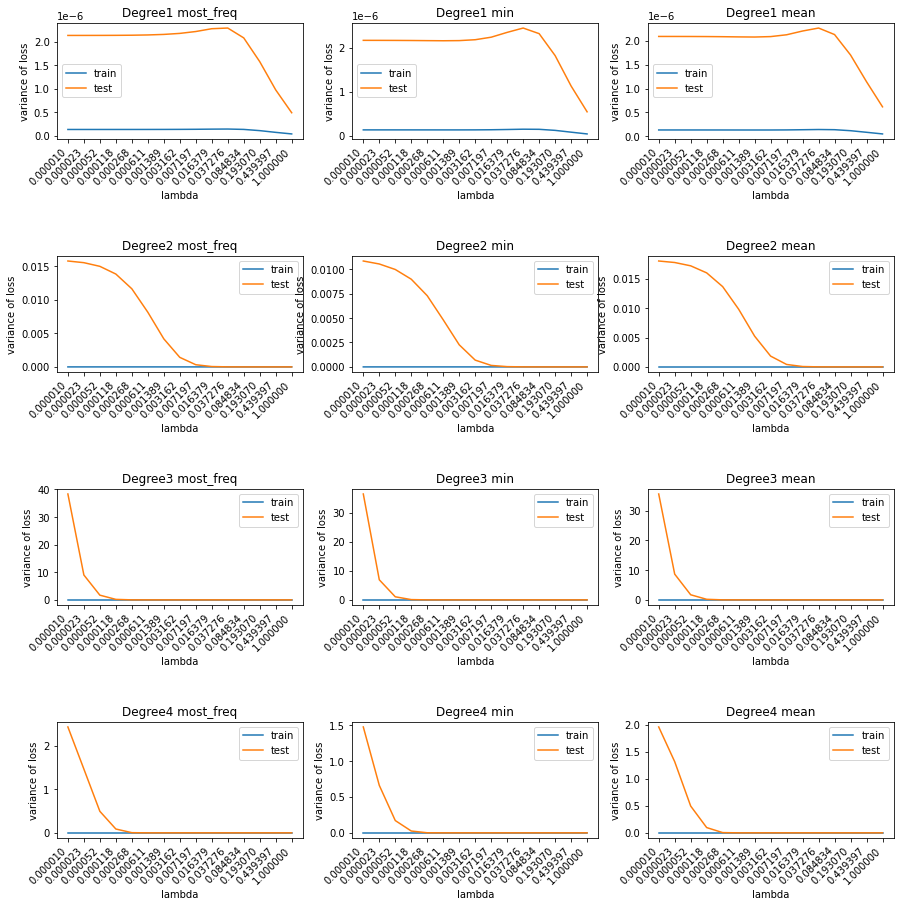

In [21]:
ROWS, COLS = (4, 3)
fig, axs = plt.subplots(ROWS, COLS, figsize=(15,15))
n = 0
offset = 0
size = 15
for row in range(ROWS):
    for col in range(COLS):
        axs[row, col].plot(all_var_loss_trs[offset:offset + size], label='train')
        axs[row, col].plot(all_var_loss_tes[offset:offset + size], label='test')
        axs[row, col].set_title(f'Degree' + str(hyperparameters[offset]['degree']) + ' ' + hyperparameters[offset]['strategy'])
        axs[row, col].legend()
        axs[row, col].set_ylabel('variance of loss')
        axs[row, col].set_xlabel('lambda')
        axs[row, col].set_xticks(range(size))
        axs[row, col].set_xticklabels(["{:.6f}".format(l) for l in lambdas], rotation = 45, ha="right")
        n += 1
        offset = n * size

fig.subplots_adjust(hspace=1)

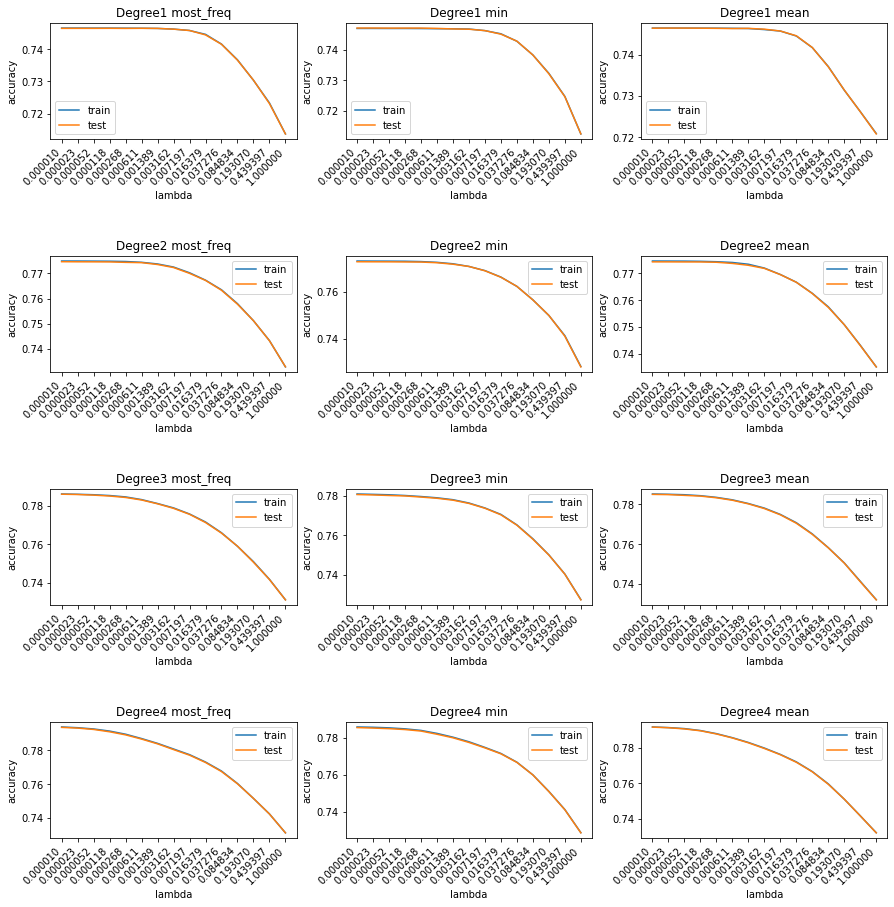

In [28]:
ROWS, COLS = (4, 3)
fig, axs = plt.subplots(ROWS, COLS,figsize=(15,15))
n = 0
offset = 0
size = 15
for row in range(ROWS):
    for col in range(COLS):
        # print(f'{hyperparameters[n]['strategy']}-D{hyperparameters[n]['degree']}-LMD{hyperparameters[n]['lambda']}')
        axs[row, col].plot(all_acc_trs[offset:offset + size], label='train')
        axs[row, col].plot(all_acc_tes[offset:offset + size], label='test')
        axs[row, col].set_title(f'Degree' + str(hyperparameters[offset]['degree']) + ' ' + hyperparameters[offset]['strategy'])
        axs[row, col].legend()
        axs[row, col].set_ylabel('accuracy')
        axs[row, col].set_xlabel('lambda')
        axs[row, col].set_xticks(range(size))
        axs[row, col].set_xticklabels(["{:.6f}".format(l) for l in lambdas], rotation = 45, ha="right")
        n += 1
        offset = n * size

fig.subplots_adjust(hspace=1)


#### Because lambda can really reduce the variance of the accuracies we can try lambda of 1 and how much degree we can go before the variance gets more than 1e-4

In [9]:
from datetime import datetime

In [10]:

k_fold = 5

# List of averaged losses, accuracies or weights of each crossvalidation
all_loss_trs = []
all_loss_tes = []

all_acc_trs = []
all_acc_tes = []

all_var_acc_trs = []
all_var_acc_tes = []

all_var_loss_trs = []
all_var_loss_tes = []
all_weights = []

times = []
hyperparameters = []
lambdas = [1]
for strategy in ['most_freq']:
    for lambda_ in lambdas:
        for degree in range(0,10):
            if degree == 0:
                continue
            print(degree)
            y, tx_train = preprocess(Y, tX, degree=degree, strategy=strategy, one_hot_enc=True, train=True, log=False)
            k_indices = build_k_indices(y, k_fold, seed)

            loss_trs = []
            loss_tes = []
            acc_trs = []
            acc_tes = []
            ws = []

            # simplify trainer for cross_validation
            trainer = lambda y, x: ridge_regression(y, x, lambda_)
            for k in range(k_fold):
                start = datetime.now()
                acc_tr, acc_te, loss_tr, loss_te, weight = cross_validation(y, tx_train, k_indices, k, trainer, compute_mse, log=False)
                stop = datetime.now()
                
                loss_trs.append(loss_tr)
                loss_tes.append(loss_te)
                acc_trs.append(acc_tr)
                acc_tes.append(acc_te)
                ws.append(weight)
            times.append((stop - start).total_seconds())
            
            mean_loss_tr = np.mean(loss_trs)
            mean_loss_te = np.mean(loss_tes)
            mean_acc_tr = np.mean(acc_trs)
            mean_acc_te = np.mean(acc_tes)

            all_loss_trs.append(mean_loss_tr)
            all_loss_tes.append(mean_loss_te)
            all_acc_trs.append(mean_acc_tr)
            all_acc_tes.append(mean_acc_te)

            var_loss_tr = np.var(loss_trs)
            var_loss_te = np.var(loss_tes)
            var_acc_tr = np.var(acc_trs)
            var_acc_te = np.var(acc_tes)

            all_var_loss_trs.append(var_loss_tr)
            all_var_loss_tes.append(var_loss_te)
            all_var_acc_trs.append(var_acc_tr)
            all_var_acc_tes.append(var_acc_te)

            hyperparameters.append({
                'lambda': lambda_,
                'degree': degree,
                'strategy': strategy,
            })

1
2
3
4
5
6
7
8
9


##### Variance is not high at all, but the computational time get longer...

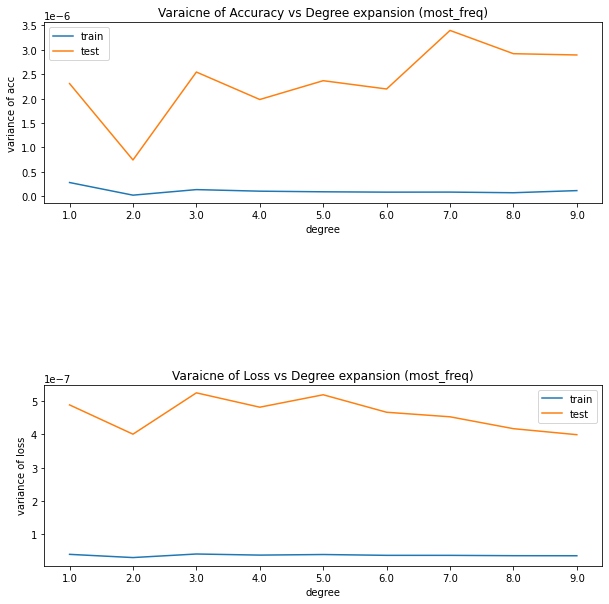

In [11]:
ROWS, COLS = (2, 1)
fig, axs = plt.subplots(ROWS, COLS, figsize=(10,10))
n = 0
offset = 0
size = 15
for row in range(ROWS):
    for col in range(COLS):
        axs[row].plot([all_var_acc_trs, all_var_loss_trs][row], label='train')
        axs[row].plot([all_var_acc_tes, all_var_loss_tes][row], label='test')
        axs[row].set_title(f'Varaicne of {["Accuracy", "Loss"][row]} vs Degree expansion ({hyperparameters[offset]["strategy"]})')
        axs[row].legend()
        axs[row].set_ylabel(f'variance of {["acc", "loss"][row]}')
        axs[row].set_xlabel('degree')
        axs[row].set_xticks(range(0,9))
        axs[row].set_xticklabels(["{:.1f}".format(l) for l in range(1,10)], rotation = 0, ha="center")
        # n += 1
        offset = n * size

fig.subplots_adjust(hspace=1)

##### Computational time is higher

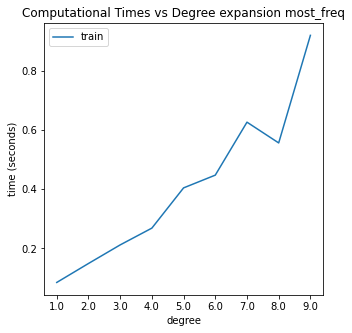

In [12]:
ROWS, COLS = (1, 1)
fig, axs = plt.subplots(ROWS, COLS, figsize=(5,5))
n = 0
offset = 0
size = 15
for row in range(ROWS):
    for col in range(COLS):
        axs.plot(times, label='train')
        axs.set_title('Computational Times vs Degree expansion' + ' ' + hyperparameters[offset]['strategy'])
        axs.legend()
        axs.set_ylabel('time (seconds)')
        axs.set_xlabel('degree')
        axs.set_xticks(range(0,9))
        axs.set_xticklabels(["{:.1f}".format(l) for l in range(1,10)], rotation = 0, ha="center")
        n += 1
        offset = n * size

fig.subplots_adjust(hspace=1)

##### Accuracy gains also lower

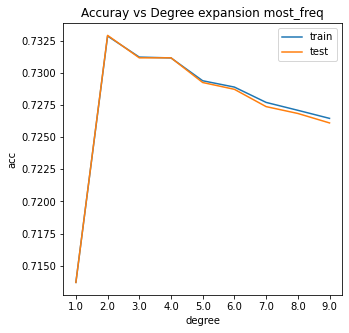

In [13]:
ROWS, COLS = (1, 1)
fig, axs = plt.subplots(ROWS, COLS, figsize=(5,5))
n = 0
offset = 0
size = 15
for row in range(ROWS):
    for col in range(COLS):
        axs.plot(all_acc_trs, label='train')
        axs.plot(all_acc_tes, label='test')
        axs.set_title('Accuray vs Degree expansion' + ' ' + hyperparameters[offset]['strategy'])
        axs.legend()
        axs.set_ylabel('acc')
        axs.set_xlabel('degree')
        axs.set_xticks(range(0,9))
        axs.set_xticklabels(["{:.1f}".format(l) for l in range(1,10)], rotation = 0, ha="center")
        n += 1
        offset = n * size

fig.subplots_adjust(hspace=1)

### Logistic Regression

In [7]:
from implementations import logistic_regression, compute_loss_logistic_regression, loss_reg_logistic_regression

#### Since this will take very long, we will roughly try to find the best candidates of hyperparameteres before dedicately train them

In [12]:
k_fold = 5
lambdas = [0, 0.01, 1]
max_iters = 21
gammas = [1e-5, 1e-6]

# List of averaged losses, accuracies or weights of each crossvalidation
all_loss_trs = []
all_loss_tes = []

all_acc_trs = []
all_acc_tes = []

all_var_loss_trs = []
all_var_loss_tes = []

all_var_acc_trs = []
all_var_acc_tes = []

all_weights = []

times = []
hyperparameters = []

def save_progress():
    global all_loss_trs, all_loss_tes, all_acc_trs, all_acc_tes, hyperparameters, times, all_var_loss_trs, all_var_loss_tes, all_var_acc_trs, all_var_acc_tes
    with open('../output/logistic_regression_models_loss_trs.npy', 'wb') as f:
        np.save(f, all_loss_trs)
    with open('../output/logistic_regression_models_loss_tes.npy', 'wb') as f:
        np.save(f, all_loss_tes)
    with open('../output/logistic_regression_models_acc_trs.npy', 'wb') as f:
        np.save(f, all_acc_trs)
    with open('../output/logistic_regression_models_acc_tes.npy', 'wb') as f:
        np.save(f, all_acc_tes)
    with open('../output/logistic_regression_models_hyper.npy', 'wb') as f:
        np.save(f, hyperparameters)
    with open('../output/logistic_regression_models_times.npy', 'wb') as f:
        np.save(f, times)
    with open('../output/logistic_regression_models_all_var_loss_trs.npy', 'wb') as f:
        np.save(f, all_var_loss_trs)
    with open('../output/logistic_regression_models_all_var_loss_tes.npy', 'wb') as f:
        np.save(f, all_var_loss_tes)
    with open('../output/logistic_regression_models_all_var_acc_trs.npy', 'wb') as f:
        np.save(f, all_var_acc_trs)
    with open('../output/logistic_regression_models_all_var_acc_tes.npy', 'wb') as f:
        np.save(f, all_var_acc_tes)

for degree in range(1,3):
    for strategy in ['most_freq', 'min', 'mean']:
        y, tx_train = preprocess(Y, tX, degree=degree, strategy=strategy, log=True, one_hot_enc=True)
        initial_w = np.zeros(tx_train.shape[1])
        k_indices = build_k_indices(y, k_fold, seed)

        for gamma in gammas:
            for lambda_ in lambdas:
                loss_trs = []
                loss_tes = []
                acc_trs = []
                acc_tes = []
                ws = []

                # simplify trainer for cross_validation
                trainer = lambda y, x: logistic_regression(y, x, lambda_, initial_w, max_iters, gamma, verbose=0)
                compute_loss = lambda y, x, w: compute_loss_logistic_regression(y, x, w) + loss_reg_logistic_regression(lambda_, w)
                for k in range(k_fold):
                    start = datetime.now()
                    acc_tr, acc_te, loss_tr, loss_te, weight = cross_validation(y, tx_train, k_indices, k, trainer, compute_loss=compute_loss, threshold=0.5, log=True)
                    stop = datetime.now()

                    loss_trs.append(loss_tr)
                    loss_tes.append(loss_te)
                    acc_trs.append(acc_tr)
                    acc_tes.append(acc_te)
                    ws.append(weight)
                times.append((stop - start).total_seconds())

                mean_loss_tr = np.mean(loss_trs)
                mean_loss_te = np.mean(loss_tes)
                mean_acc_tr = np.mean(acc_trs)
                mean_acc_te = np.mean(acc_tes)

                all_loss_trs.append(mean_loss_tr)
                all_loss_tes.append(mean_loss_te)
                all_acc_trs.append(mean_acc_tr)
                all_acc_tes.append(mean_acc_te)

                print(loss_tes)
                var_loss_tr = np.var(loss_trs)
                var_loss_te = np.var(loss_tes)
                var_acc_tr = np.var(acc_trs)
                var_acc_te = np.var(acc_tes)

                all_var_loss_trs.append(var_loss_tr)
                all_var_loss_tes.append(var_loss_te)
                all_var_acc_trs.append(var_acc_tr)
                all_var_acc_tes.append(var_acc_te)

                print('took', times[-1], 's')
                print(format_result(mean_loss_tr, mean_loss_te, mean_acc_tr, mean_acc_te, var_acc_tr, var_acc_te, var_loss_tr, var_loss_te, for_spreadsheet=False))
                print(format_result(mean_loss_tr, mean_loss_te, mean_acc_tr, mean_acc_te, var_acc_tr, var_acc_te, var_loss_tr, var_loss_te, for_spreadsheet=True))

                hyperparameters.append({
                    'lambda': lambda_,
                    'gamma': gamma,
                    'degree': degree,
                    'strategy': strategy,
                })
                print('hyperparameters', hyperparameters[-1])
                save_progress()

[28755.7060102713, 28893.688926774765, 28586.22857230803, 28687.929528171768, 28967.99514319098]
took 9.44735 s
Summary: 
	        train loss: 115087.61296055079
	        test loss: 28778.309636143367
	        train acc: 0.7257629999999999
	        test acc: 0.7258039999999999
	        train var acc: 7.153159999999478e-07
	        test var acc: 6.56166400000013e-06
	

        train var loss: 99182.07276379368
	        test var loss: 18973.519038830196
	        
Summary: 
        115087.61296055079
        28778.309636143367
        0.7257629999999999
        0.7258039999999999
        7.153159999999478e-07
        6.56166400000013e-06


        99182.07276379368
        18973.519038830196
        
hyperparameters {'lambda': 0, 'gamma': 1e-05, 'degree': 1, 'strategy': 'most_freq'}
[28755.71239863515, 28893.695311272975, 28586.235089489524, 28687.936014566105, 28968.001696667277]
took 11.50357 s
Summary: 
	        train loss: 115087.63739171231
	        test loss: 28778.316102126206
	   

In [13]:
k_fold = 5
lambdas = [0, 0.01, 1]
max_iters = 21
gammas = [1e-5, 1e-6]
degrees = [1,2,3,4]
strategies = ['most_freq', 'min', 'mean']

for degree in range(3,5):
    for strategy in ['most_freq', 'min', 'mean']:
        y, tx_train = preprocess(Y, tX, degree=degree, strategy=strategy, log=True, one_hot_enc=True)
        initial_w = np.zeros(tx_train.shape[1])
        k_indices = build_k_indices(y, k_fold, seed)

        for gamma in gammas:
            for lambda_ in lambdas:
                loss_trs = []
                loss_tes = []
                acc_trs = []
                acc_tes = []
                ws = []

                # simplify trainer for cross_validation
                trainer = lambda y, x: logistic_regression(y, x, lambda_, initial_w, max_iters, gamma, verbose=0)
                compute_loss = lambda y, x, w: compute_loss_logistic_regression(y, x, w) + loss_reg_logistic_regression(lambda_, w)
                for k in range(k_fold):
                    start = datetime.now()
                    acc_tr, acc_te, loss_tr, loss_te, weight = cross_validation(y, tx_train, k_indices, k, trainer, compute_loss=compute_loss, threshold=0.5, log=True)
                    stop = datetime.now()

                    loss_trs.append(loss_tr)
                    loss_tes.append(loss_te)
                    acc_trs.append(acc_tr)
                    acc_tes.append(acc_te)
                    ws.append(weight)
                times.append((stop - start).total_seconds())

                mean_loss_tr = np.mean(loss_trs)
                mean_loss_te = np.mean(loss_tes)
                mean_acc_tr = np.mean(acc_trs)
                mean_acc_te = np.mean(acc_tes)

                all_loss_trs.append(mean_loss_tr)
                all_loss_tes.append(mean_loss_te)
                all_acc_trs.append(mean_acc_tr)
                all_acc_tes.append(mean_acc_te)

                print(loss_tes)
                var_loss_tr = np.var(loss_trs)
                var_loss_te = np.var(loss_tes)
                var_acc_tr = np.var(acc_trs)
                var_acc_te = np.var(acc_tes)

                all_var_loss_trs.append(var_loss_tr)
                all_var_loss_tes.append(var_loss_te)
                all_var_acc_trs.append(var_acc_tr)
                all_var_acc_tes.append(var_acc_te)

                print('took', times[-1], 's')
                print(format_result(mean_loss_tr, mean_loss_te, mean_acc_tr, mean_acc_te, var_acc_tr, var_acc_te, var_loss_tr, var_loss_te, for_spreadsheet=False))
                print(format_result(mean_loss_tr, mean_loss_te, mean_acc_tr, mean_acc_te, var_acc_tr, var_acc_te, var_loss_tr, var_loss_te, for_spreadsheet=True))

                hyperparameters.append({
                    'lambda': lambda_,
                    'gamma': gamma,
                    'degree': degree,
                    'strategy': strategy,
                })
                print('hyperparameters', hyperparameters[-1])
                save_progress()

[32672.856532288013, 33006.61317758631, 32650.009932278594, 32623.304702605892, 33448.39813001736]
took 10.677884 s
Summary: 
	        train loss: 131458.25704817614
	        test loss: 32880.236494955236
	        train acc: 0.729954
	        test acc: 0.7297559999999998
	        train var acc: 2.2363399999998653e-07
	        test var acc: 5.215744000000004e-06
	

        train var loss: 214666.32301074424
	        test var loss: 100160.67489338212
	        
Summary: 
        131458.25704817614
        32880.236494955236
        0.729954
        0.7297559999999998
        2.2363399999998653e-07
        5.215744000000004e-06


        214666.32301074424
        100160.67489338212
        
hyperparameters {'lambda': 0, 'gamma': 1e-05, 'degree': 3, 'strategy': 'most_freq'}
[32672.856930972954, 33006.613537223646, 32650.010392644068, 32623.305125846353, 33448.398566823664]
took 8.972012 s
Summary: 
	        train loss: 131458.2582316245
	        test loss: 32880.23691070214
	        train 

In [22]:
indices = [i for i, hp in enumerate(hyperparameters) if hp['strategy']=='most_freq' and hp['gamma']==1e-6 and hp['lambda']==1]

for i in indices:
    print(i, hyperparameters[i])
    print(np.array(all_acc_trs)[i])
    print(np.array(all_acc_tes)[i])
    # print(np.array(all_var_loss_trs)[i])
    # print(np.array(all_var_loss_tes)[i])
    print(np.array(all_var_acc_trs)[i])
    print(np.array(all_var_acc_tes)[i])

# i = 170
# print(hyperparameters[i])
# print(format_result(all_loss_trs[i],all_loss_tes[i],all_acc_trs[i],all_acc_tes[i],all_var_acc_trs[i],all_var_acc_tes[i], for_spreadsheet=True))


5 {'lambda': 1, 'gamma': 1e-06, 'degree': 1, 'strategy': 'most_freq'}
0.7223500000000002
0.7222839999999999
3.465100000000075e-07
3.363903999999911e-06
23 {'lambda': 1, 'gamma': 1e-06, 'degree': 2, 'strategy': 'most_freq'}
0.744513
0.744472
7.165599999999598e-08
1.516095999999995e-06
41 {'lambda': 1, 'gamma': 1e-06, 'degree': 3, 'strategy': 'most_freq'}
0.7426950000000001
0.7425919999999999
1.011899999999989e-07
2.127935999999987e-06
59 {'lambda': 1, 'gamma': 1e-06, 'degree': 4, 'strategy': 'most_freq'}
0.743428
0.7432479999999999
4.402600000000455e-08
1.8365760000000416e-06


In [19]:
len(hyperparameters) , len(all_var_loss_trs)

(72, 0)

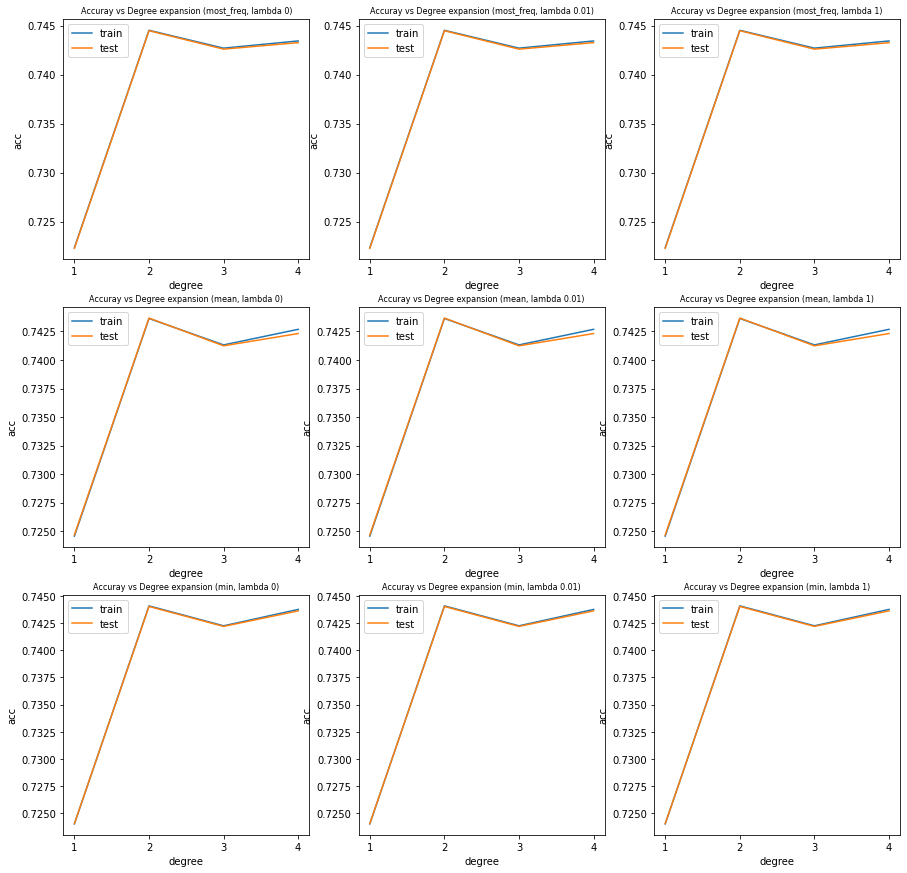

In [34]:


ROWS, COLS = (3, 3)
fig, axs = plt.subplots(ROWS, COLS, figsize=(15,15))

lambdas
hps = ['most_freq', 'mean', 'min']

for row in range(ROWS):
    for col in range(COLS):
        indices = [i for i, hp in enumerate(hyperparameters) if hp['strategy']==hps[row] and hp['gamma']==1e-6 and hp['lambda']==lambdas[col]]

        axs[row, col].plot([all_acc_trs[i] for i in indices], label='train')
        axs[row, col].plot([all_acc_tes[i] for i in indices], label='test')
        axs[row, col].set_title('Accuray vs Degree expansion' + ' ' + f'({hps[row]}, lambda {lambdas[col]})', fontsize=8)
        axs[row, col].legend()
        axs[row, col].set_ylabel('acc')
        axs[row, col].set_xlabel('degree')
        axs[row, col].set_xticks(range(0,4))
        axs[row, col].set_xticklabels(["{}".format(l) for l in range(1,5)], rotation = 0, ha="center")


In [91]:
def load_progress():
    global times, loss_trs, loss_tes, acc_trs, acc_tes, hyperparameters
    with open('../output/logistic_regression_models_loss_trs.npy', 'rb') as f:
        loss_trs = np.load(f, allow_pickle=True)
    with open('../output/logistic_regression_models_loss_tes.npy', 'rb') as f:
        loss_tes = np.load(f, allow_pickle=True)
    with open('../output/logistic_regression_models_acc_trs.npy', 'rb') as f:
        acc_trs = np.load(f, allow_pickle=True)
    with open('../output/logistic_regression_models_acc_tes.npy', 'rb') as f:
        acc_tes = np.load(f, allow_pickle=True)
    with open('../output/logistic_regression_models_hyper.npy', 'rb') as f:
        hyperparameters = np.load(f, allow_pickle=True)
    with open('../output/logistic_regression_models_times.npy', 'rb') as f:
        times = np.load(f, allow_pickle=True)
load_progress()
hyperparameters[-1]
k_fold = 5
lambdas = [1, 0.01, 0.0001, 0]
max_iters = 101
gammas = [1e-5, 1e-6]

In [93]:
times[0], hyperparameters[0]

(1.016173, {'lambda': 0, 'gamma': 1e-05, 'degree': 1, 'strategy': 'most_freq'})

In [9]:
indices = [i for i, d in enumerate(hyperparameters) if d['strategy'] == 'mean' and d['degree'] == 1]
idx = np.argmax(acc_tes[indices])
acc_trs[indices][idx], acc_tes[indices][idx], loss_trs[indices][idx], loss_tes[indices][idx], hyperparameters[indices][idx]

(0.7514350000000001,
 0.751352,
 99347.38136788223469,
 24844.328135152954392,
 {'lambda': 0.01,
  'gamma': 1e-05,
  'degree': 1,
  'strategy': 'mean',
  'one_hot_enc': True})

In [14]:
indices = [i for i, d in enumerate(hyperparameters) if d['strategy'] == 'mean' and d['degree'] == 2]
idx = np.argmax(acc_tes[indices])
acc_trs[indices][idx], acc_tes[indices][idx], loss_trs[indices][idx], loss_tes[indices][idx], hyperparameters[indices][idx]

(0.7613489999999999,
 0.7614240000000001,
 97702.72654904652079,
 24433.59605921237962,
 {'lambda': 1,
  'gamma': 1e-06,
  'degree': 2,
  'strategy': 'mean',
  'one_hot_enc': True})

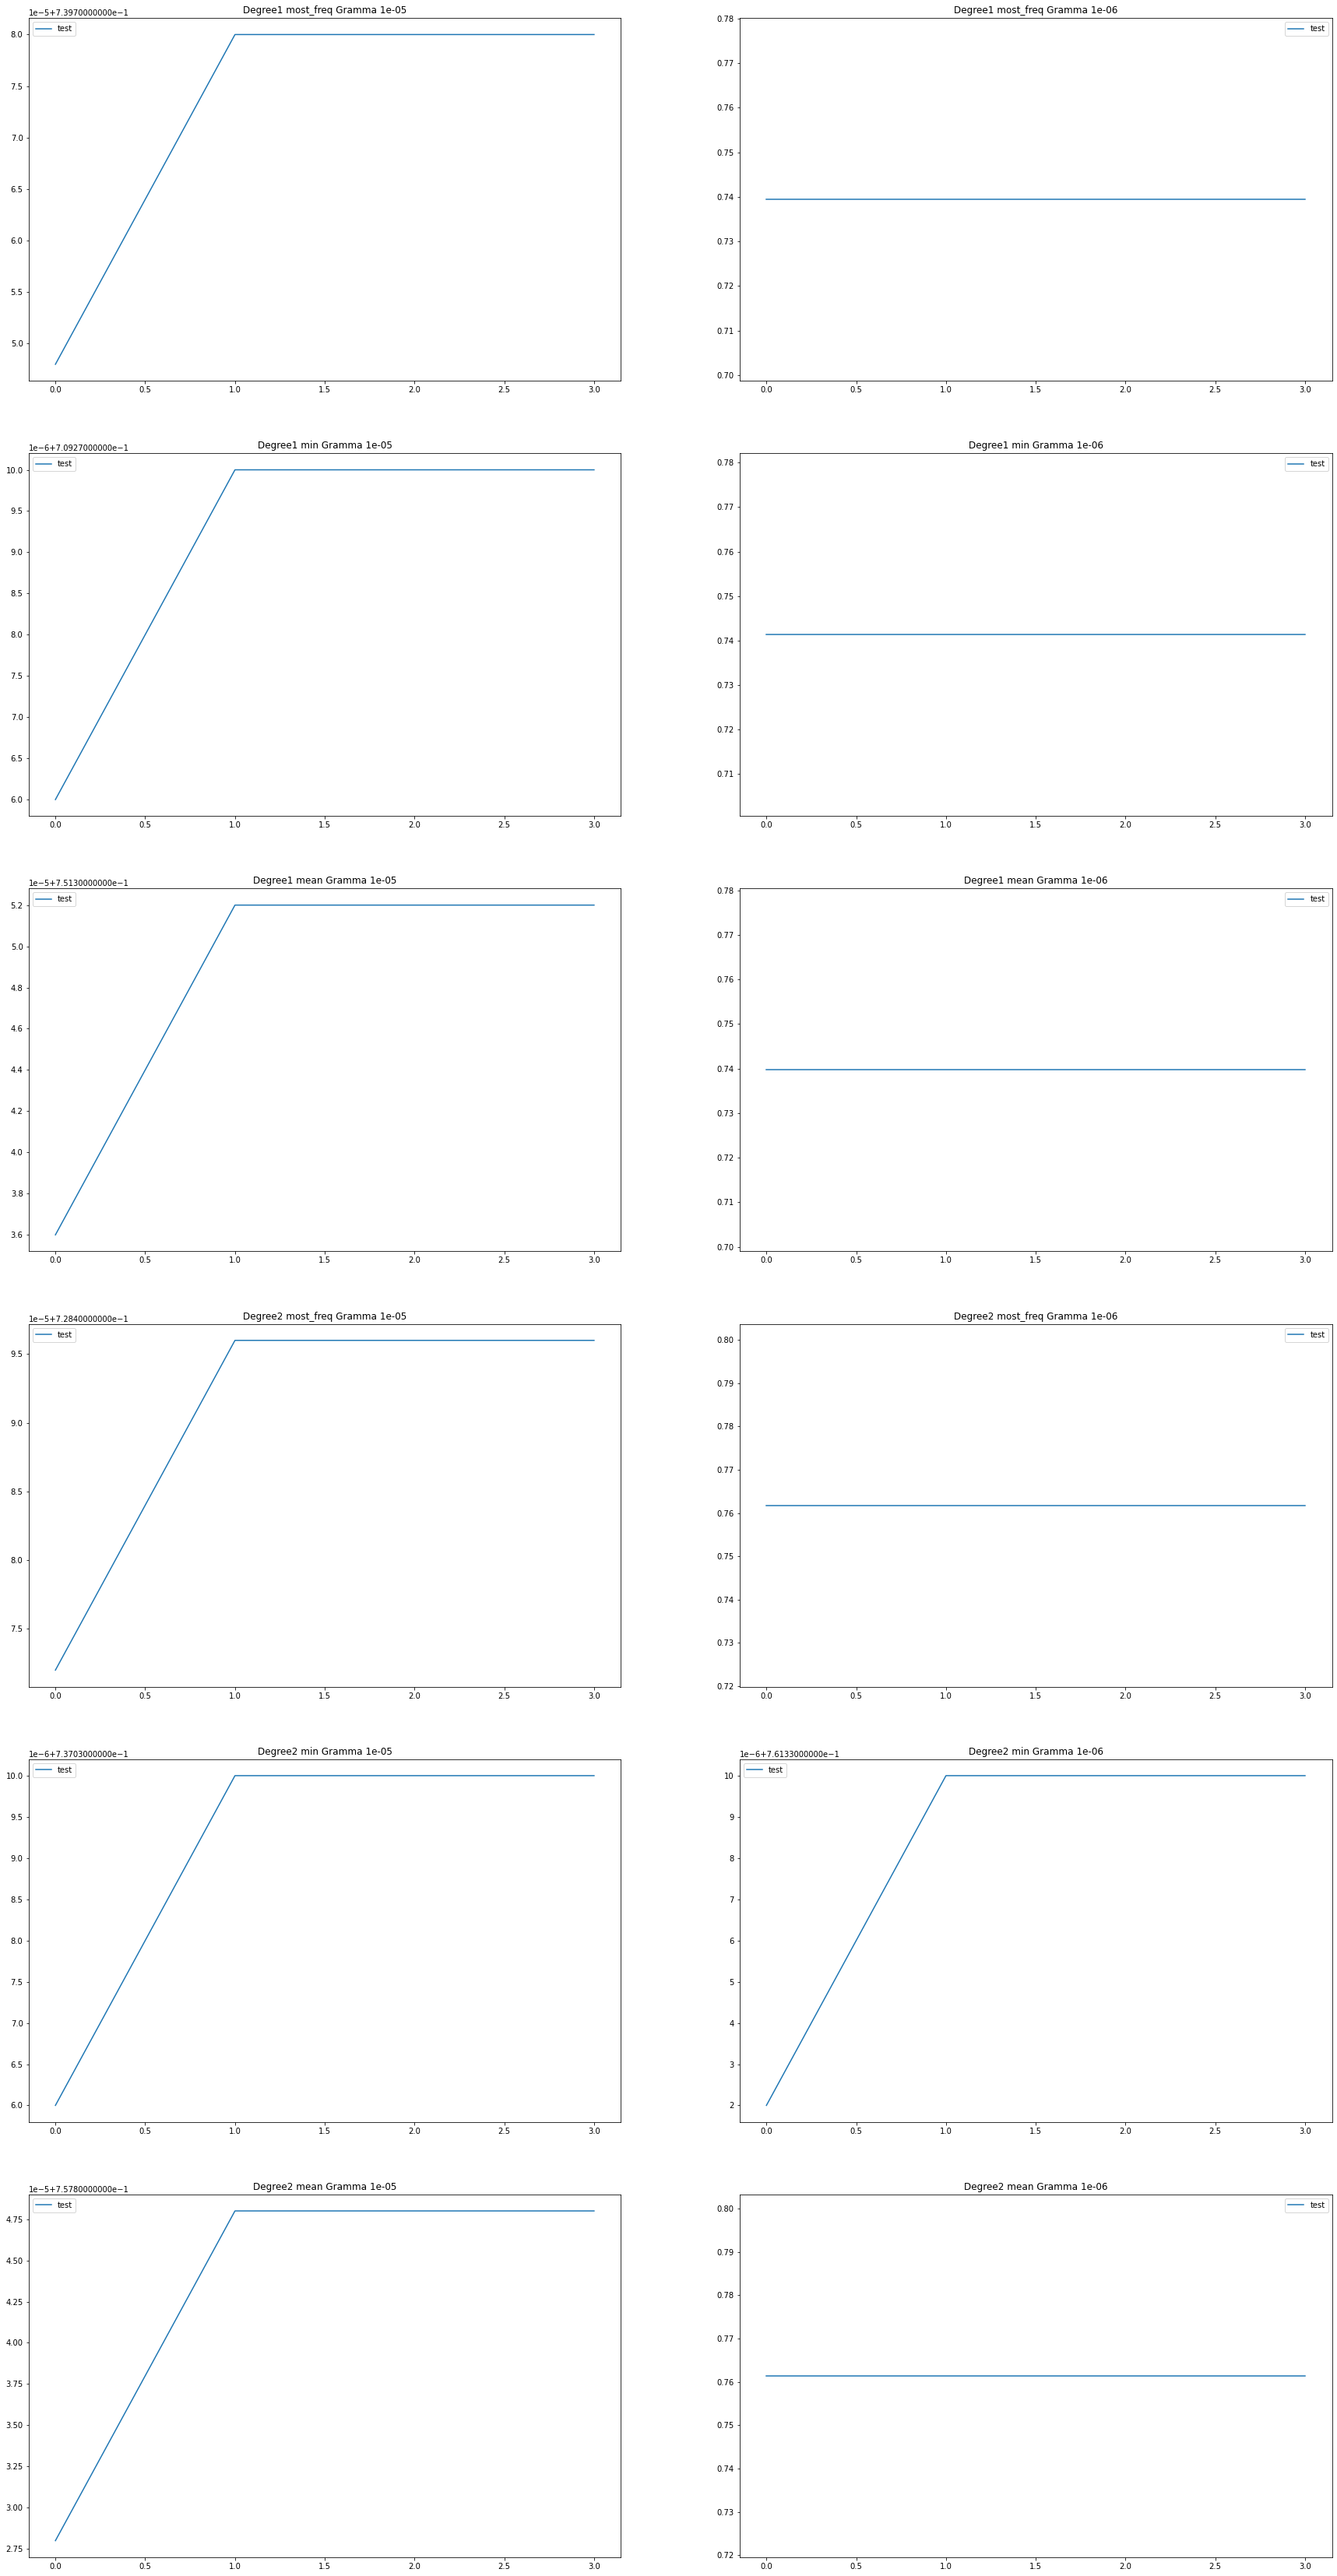

In [33]:
ROWS, COLS = (6, 2)
fig, axs = plt.subplots(ROWS, COLS,figsize=(30,60))
n = 0
offset = 0
size = 4
for row in range(ROWS):
    for col in range(COLS):
        # print(f'{hyperparameters[n]['strategy']}-D{hyperparameters[n]['degree']}-LMD{hyperparameters[n]['lambda']}')
        # axs[row, col].plot(lambdas, acc_trs[offset:offset + size], label='train')
        axs[row, col].plot(acc_tes[offset:offset + size], label='test')
        axs[row, col].set_title(f'Degree' + str(hyperparameters[offset]['degree']) + ' ' + hyperparameters[offset]['strategy'] + ' Gramma ' + str(hyperparameters[offset]['gamma']))
        axs[row, col].legend()
        # axs[row, col].set_xticklabels(lambdas, rotation = 45, ha="right")
        n += 1
        offset = n * size

### Saving models

In [45]:
with open('least_squre_normalized_poly2_onehot_alldata.npy', 'wb') as f:
    np.save(f, ws)

Continue training

In [ ]:
from cross_validation import make_prediction

## Generate predictions and save ouput in csv format for submission:

In [96]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
_, tX_test = preprocess(_, tX_test, degree=2, strategy='most_freq', train=False)


(568238, 30) before
(568238, 29) remove col to be one hot


In [97]:
tX_test.shape

(568238, 63)

In [98]:
OUTPUT_PATH = '../output/logistic_regression_N_Md_D3_1H_lam1_gam1e-06_trainall_2000.csv' 
y_pred = make_prediction(tX_test, weighted_mean, threshold=0, log=False)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)